## 1. Make classification data and get it ready

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_circles

import torch
from torch import nn

In [2]:
# using make_circles() method from scikit-Learn to generate two circles with different colored dots.

n_samples=1000

#Create circles

X,y= make_circles(n_samples,
                 noise=0.03,
                 random_state=43)

In [3]:
#Make dataframe of circle data
circles=pd.DataFrame({'X1':X[:,0], 
                      'X2':X[:,1], 
                       'label':y}) 

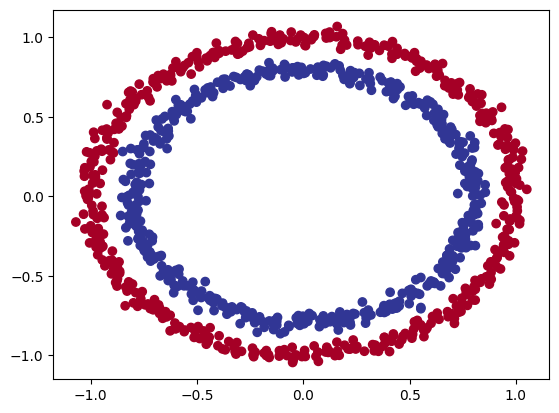

In [4]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)  

### 1.1 Check input and output shape
Checking input and output shape is important. \
Shape errors are common erros in deep learning. 

In [5]:
X.shape,y.shape

((1000, 2), (1000,))

### 1.2 Changing data into tensors and create train, test splits

In [6]:
X=torch.tensor(X,dtype=torch.float32)
y=torch.tensor(y,dtype=torch.float32)

In [7]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=43)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## 2. Building the model
1. Set device
2. Subclass nn.Module
3. Define loss and optimizer
4. Create training loop

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [9]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2 , out_features=5)
        self.layer2=nn.Linear(in_features=5 , out_features=1)
    def forward(self,x):
        return self.layer2(self.layer1(x)) # x goes to layer 1 first and goes to layer 2
        
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# Replicate CircleModelV0 with nn.Sequential
# nn.Sequential performs a forward pass computation 
#of the input data through the layers in the order they appear.
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

#### so why not always use nn.Sequential? \
nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [11]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5232, -0.0577],
                      [-0.3896,  0.2202],
                      [ 0.2807,  0.5818],
                      [-0.3971,  0.4841],
                      [ 0.3472, -0.4205]])),
             ('layer1.bias',
              tensor([ 0.6621,  0.6696, -0.2995,  0.4266, -0.6876])),
             ('layer2.weight',
              tensor([[-0.2565,  0.1127, -0.3602, -0.1675,  0.1397]])),
             ('layer2.bias', tensor([-0.2189]))])

In [12]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2273],
        [-0.1593],
        [-0.3518],
        [-0.6607],
        [-0.6555],
        [-0.3034],
        [-0.4173],
        [-0.5686],
        [-0.5045],
        [-0.3350]])

First 10 test labels:
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 1.])


### 2.1 Setup loss function and optimizer

As we are performing binary classification, we shall prefer binary cross entropy as loss funciton here. <br> 
Additionally, pytorch has two binary cross entropy implementaitons:
- `torch.nn.BCELoss()`
- `torch.nn.BCELosswithLogitsLoss()`: has the sigmoid layer built-in

#### which one should we use?
The documentation of `torch.nn.BCEwtihLogitsLoss()` states that it's more numerically stabel than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. so 2nd one might be a better option.

In [13]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
a=[1,2,3,4]
b=[1,2,3,3]
a=torch.from_numpy(np.array(a))
b=torch.tensor([1,2,3,3])
torch.eq(a,b).sum().item()
# .sum() sums the number of true and item will onlt show the value inside the bracket

3

## 3. Train the model
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. loss backward
5. optimizer step / gradient descent

In [16]:
y_logits = model_0(X_test.to(device))[:5]
y_logits # this raw output that we got from the model is called logits.

tensor([[-0.2273],
        [-0.1593],
        [-0.3518],
        [-0.6607],
        [-0.6555]], grad_fn=<SliceBackward0>)

In [17]:
# Using sigmoid on logits
# sigmoid will change the logits into prediction probability
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4434],
        [0.4603],
        [0.4129],
        [0.3406],
        [0.3418]], grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_prob)
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

### 3.1 Build training and testing loop

In [19]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train() # set model to training mode

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71635, Accuracy: 49.75% | Test loss: 0.71498, Test acc: 48.50%
Epoch: 10 | Loss: 0.70101, Accuracy: 47.50% | Test loss: 0.70499, Test acc: 47.50%
Epoch: 20 | Loss: 0.69724, Accuracy: 49.12% | Test loss: 0.70287, Test acc: 48.00%
Epoch: 30 | Loss: 0.69610, Accuracy: 50.38% | Test loss: 0.70220, Test acc: 47.50%
Epoch: 40 | Loss: 0.69559, Accuracy: 50.88% | Test loss: 0.70172, Test acc: 46.50%
Epoch: 50 | Loss: 0.69525, Accuracy: 51.12% | Test loss: 0.70127, Test acc: 47.00%
Epoch: 60 | Loss: 0.69499, Accuracy: 50.88% | Test loss: 0.70083, Test acc: 47.00%
Epoch: 70 | Loss: 0.69476, Accuracy: 50.62% | Test loss: 0.70041, Test acc: 47.00%
Epoch: 80 | Loss: 0.69457, Accuracy: 51.00% | Test loss: 0.70003, Test acc: 47.00%
Epoch: 90 | Loss: 0.69441, Accuracy: 51.25% | Test loss: 0.69967, Test acc: 47.00%
Epoch: 100 | Loss: 0.69427, Accuracy: 51.12% | Test loss: 0.69935, Test acc: 47.00%
Epoch: 110 | Loss: 0.69414, Accuracy: 51.00% | Test loss: 0.69906, Test acc: 47.50%
Epo

## 4. Make predictions and evaluate the model

In [20]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

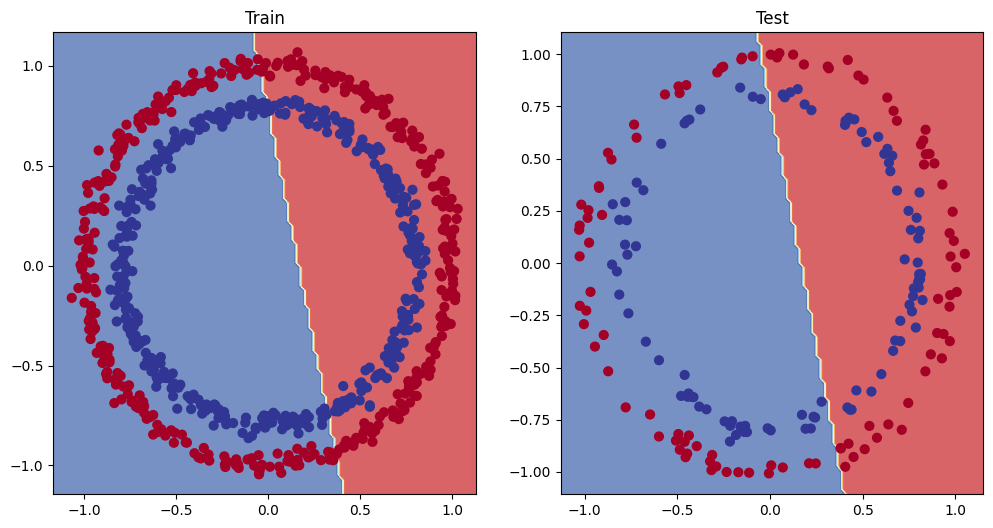

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model
- Add more layers
- Add more hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
  

In [22]:
# addding extra layers to check the result
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [24]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69313, Accuracy: 51.88% | Test loss: 0.69626, Test acc: 47.00%
Epoch: 100 | Loss: 0.69300, Accuracy: 51.75% | Test loss: 0.69495, Test acc: 46.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.50% | Test loss: 0.69472, Test acc: 47.00%
Epoch: 300 | Loss: 0.69299, Accuracy: 51.75% | Test loss: 0.69467, Test acc: 47.50%
Epoch: 400 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%
Epoch: 500 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%
Epoch: 600 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%
Epoch: 700 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%
Epoch: 800 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%
Epoch: 900 | Loss: 0.69299, Accuracy: 51.88% | Test loss: 0.69466, Test acc: 47.50%


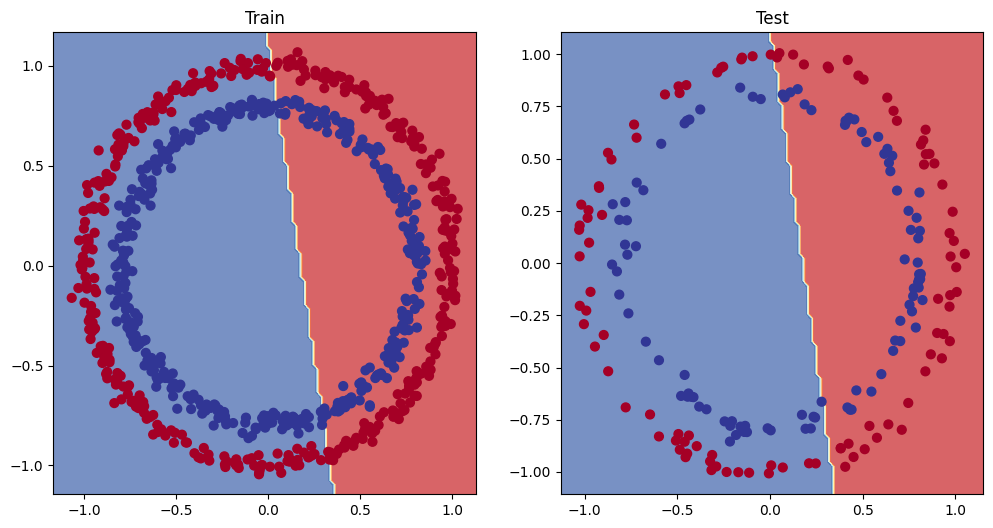

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

we can observe, the addition of an extra layer made no significant improvement in the model's performance

### 5.1 checking whether our model can model a straight line

In [26]:
# creating some random data
weight=0.7
bias=0.3
start = 2
end  =  3
step =0.01

X= torch.arange(start,end,step).unsqueeze(dim=1)
y= weight*X + bias

In [27]:
# Create train test split
train_split= int(0.8*len(X))

X_train, y_train= X[:train_split] , y[:train_split]
X_test, y_test= X[train_split:], y[train_split:]


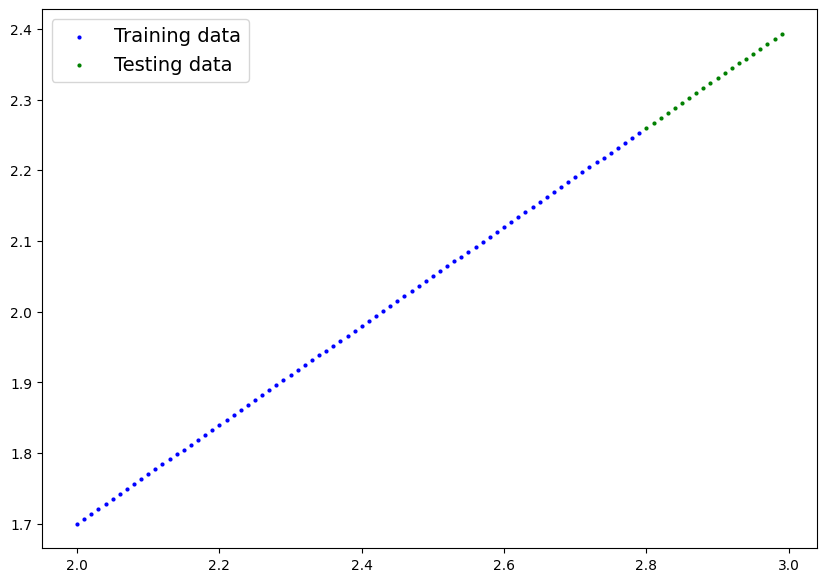

In [28]:
plot_predictions(train_data=X_train, 
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

### 5.2 Adjusting our model to fit the line

In [29]:
model_2= nn.Sequential(
        nn.Linear(in_features=1,  out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1)
).to(device)

In [30]:
#set loss and optimizer
loss_fnn=nn.L1Loss()
optimizer=torch.optim.SGD(model_2.parameters(),lr=0.1)

In [31]:
#training the model
torch.manual_seed(43)

epochs=1000
X_train,y_train= X_train.to(device), y_train.to(device)
X_test,y_test= X_test.to(device),y_test.to(device)

for eopch in range(epochs):
    model_2.train()

    #forward pass
    y_pred=model_2(X_train)

    #calcualte the loss
    loss=loss_fnn(y_pred,y_train)

    #optimizer zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #gradient descent
    optimizer.step()

    ##Testing
    model_2.eval()
    with torch.inference_mode():
        #forward pass
        test_preds=model_2(X_test)

        #calc loss
        test_loss=loss_fnn(test_preds,y_test)

        if epoch % 100==0:
            #display the progress
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f}| Test Loss: {test_loss:.4f} ")
        

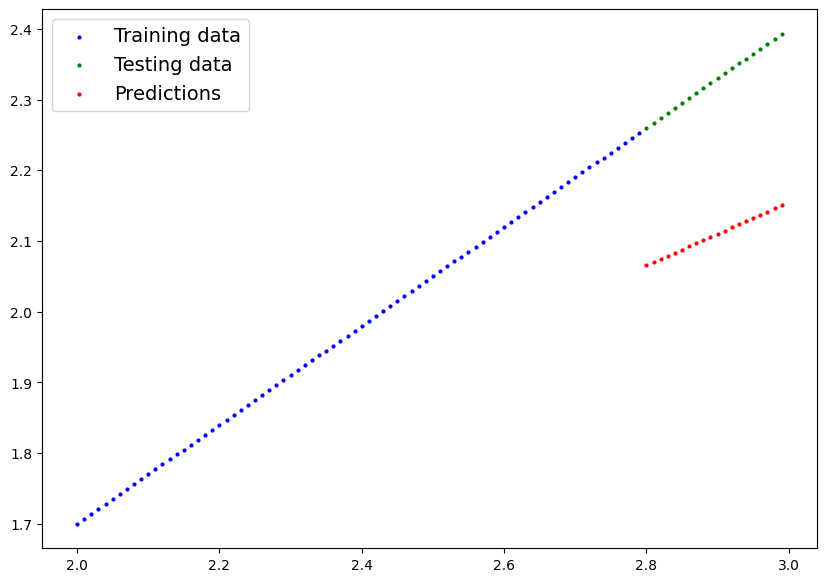

In [32]:
#plotting the prediction
model_2.eval()
with torch.inference_mode():
    y_preds=model_2(X_test)

plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

### 6. Using ReLU

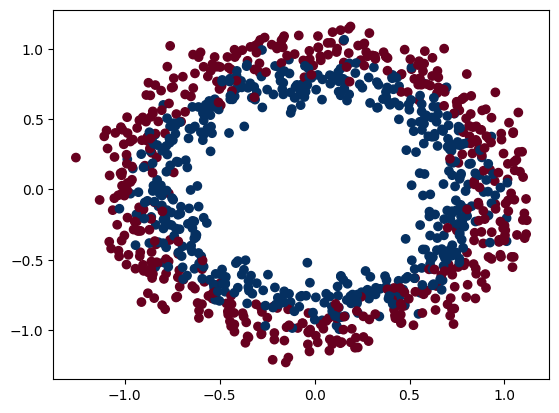

In [33]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.1,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [34]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.7254, -0.3969],
         [ 0.5307, -0.7280],
         [-1.0552, -0.0629],
         [-0.9480, -0.2288],
         [-0.1596,  0.8406]]),
 tensor([1., 0., 0., 0., 1.]))

In [35]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=512)
        self.layer_2 = nn.Linear(in_features=512, out_features=512)
        self.layer_3 = nn.Linear(in_features=512, out_features=512)
        self.layer_4 = nn.Linear(in_features=512, out_features=1)
        self.relu = nn.RReLU() # <- add in ReLU activation function
    

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=1, bias=True)
  (relu): RReLU(lower=0.125, upper=0.3333333333333333)
)


In [36]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), 
                            lr=0.1)

In [37]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69278, Accuracy: 53.25% | Test Loss: 0.69335, Test Accuracy: 48.50%
Epoch: 100 | Loss: 0.64950, Accuracy: 82.75% | Test Loss: 0.66625, Test Accuracy: 68.00%
Epoch: 200 | Loss: 0.57214, Accuracy: 61.38% | Test Loss: 0.66186, Test Accuracy: 58.00%
Epoch: 300 | Loss: 0.49141, Accuracy: 73.12% | Test Loss: 0.63772, Test Accuracy: 65.50%
Epoch: 400 | Loss: 0.43021, Accuracy: 79.88% | Test Loss: 0.62718, Test Accuracy: 66.00%
Epoch: 500 | Loss: 0.38408, Accuracy: 82.38% | Test Loss: 0.61687, Test Accuracy: 67.00%
Epoch: 600 | Loss: 0.34442, Accuracy: 83.75% | Test Loss: 0.59576, Test Accuracy: 68.00%
Epoch: 700 | Loss: 0.35434, Accuracy: 83.00% | Test Loss: 0.63510, Test Accuracy: 68.50%
Epoch: 800 | Loss: 0.33367, Accuracy: 84.88% | Test Loss: 0.61547, Test Accuracy: 68.50%
Epoch: 900 | Loss: 0.31783, Accuracy: 85.62% | Test Loss: 0.59171, Test Accuracy: 72.50%


In [38]:
# make prediction
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

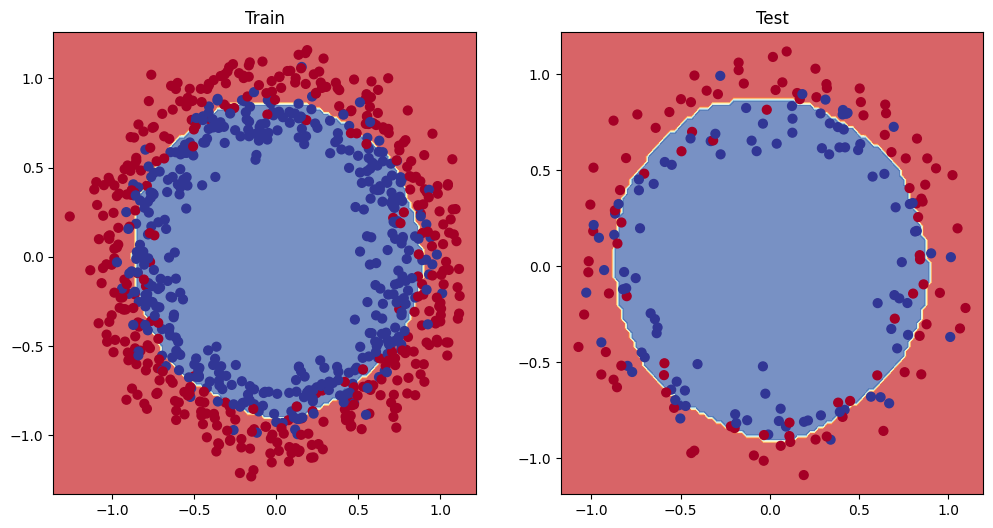

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Multiclass

### 7.1 creating the dataset for multi-class classification problem

In [40]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [41]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


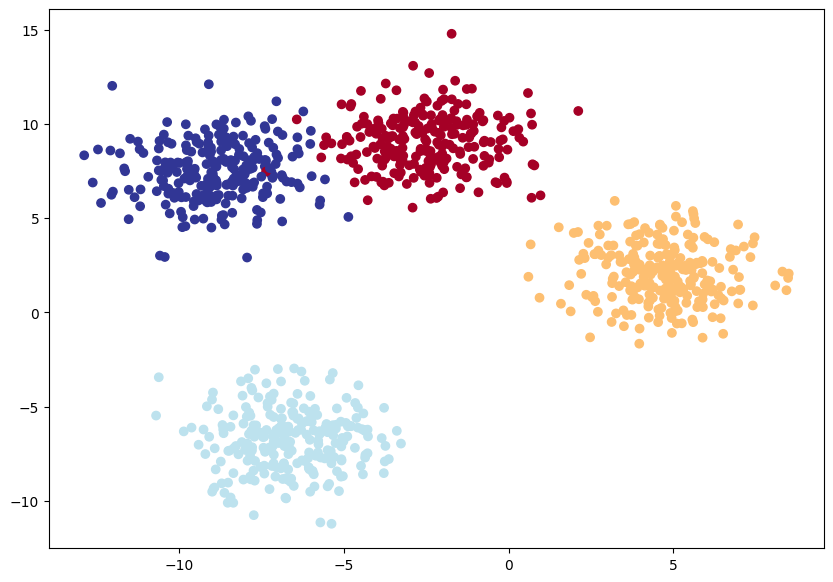

In [42]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 7.2 Building the model

In [43]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [45]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [46]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.2920, -0.8715, -0.2724, -1.2972],
        [ 0.3881, -3.0431,  2.7527,  0.3325],
        [ 0.6097,  1.3839,  0.3698,  0.6954],
        [ 0.5365,  0.3604,  0.7214,  0.4173],
        [ 0.4153, -2.4914,  2.4521,  0.3742]], grad_fn=<SliceBackward0>)

In [47]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [48]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2911, -1.2064,  0.0519, -1.1844],
        [ 0.4997, -2.7361,  3.4599,  1.2074],
        [ 0.5626,  1.2352,  0.0902,  0.3329],
        [ 0.3294, -0.4120, -0.3888, -1.1320],
        [ 0.3401, -3.0326,  2.3078, -0.0944]], grad_fn=<SliceBackward0>)
tensor([[0.4465, 0.0999, 0.3515, 0.1021],
        [0.0447, 0.0018, 0.8628, 0.0907],
        [0.2284, 0.4476, 0.1424, 0.1816],
        [0.4554, 0.2170, 0.2221, 0.1056],
        [0.1132, 0.0039, 0.8097, 0.0733]], grad_fn=<SliceBackward0>)


### 7.3 Training loop

In [49]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.05878, Acc: 6.38% | Test Loss: 0.90037, Test Acc: 56.00%
Epoch: 10 | Loss: 0.21640, Acc: 98.12% | Test Loss: 0.18559, Test Acc: 98.50%
Epoch: 20 | Loss: 0.10030, Acc: 99.25% | Test Loss: 0.09166, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06830, Acc: 99.25% | Test Loss: 0.06081, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05393, Acc: 99.38% | Test Loss: 0.04642, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04600, Acc: 99.38% | Test Loss: 0.03830, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04106, Acc: 99.38% | Test Loss: 0.03314, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03772, Acc: 99.38% | Test Loss: 0.02959, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03532, Acc: 99.38% | Test Loss: 0.02700, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03353, Acc: 99.38% | Test Loss: 0.02503, Test Acc: 99.50%


In [50]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]


tensor([[  5.6756,  11.3629, -10.6487,  -7.9211],
        [  3.4698, -12.6034,   1.9789,   8.7734],
        [ -8.3598, -14.6637,  16.3221,   8.3388],
        [  2.5614,   8.2121,  -5.7718,  -6.1800],
        [  8.8516,   4.0213, -11.1675,  -2.1883],
        [  3.7127, -15.6935,   3.0064,  11.0107],
        [ -8.3681, -11.3063,  14.9145,   5.9492],
        [  7.2216,  -0.3839,  -7.4518,   0.6836],
        [ -9.0556, -20.2976,  19.4925,  12.2349],
        [  7.6791,   1.2176,  -8.6487,  -0.3822]])

In [51]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


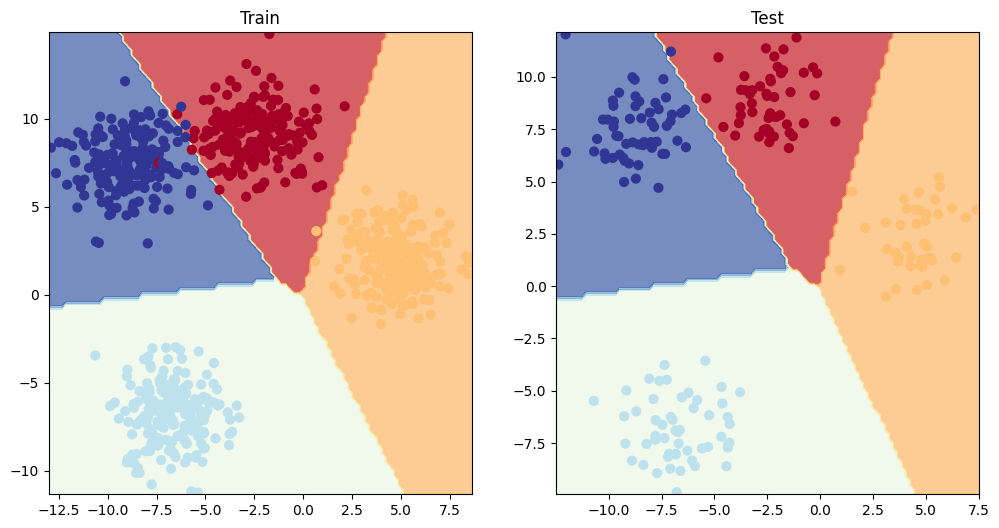

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)